In [1]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

kf = KFold(n_splits=15, shuffle=True, random_state=15)

In [2]:
# Load and preprocess data
data = pd.read_excel('P5_emergency_department.xlsx')
X = data.drop(['CLASS', 'PATIENT'], axis=1)
y = data['CLASS']
y = y.map({'URGENT': 1, 'NOT URGENT': 0})
y.value_counts()

CLASS
0    8
1    7
Name: count, dtype: int64

0.26666666666666666
0.6
0.5333333333333333
0.5333333333333333
0.5333333333333333
0.4666666666666667
0.4666666666666667
0.4666666666666667
0.4666666666666667
Best max depth is 2


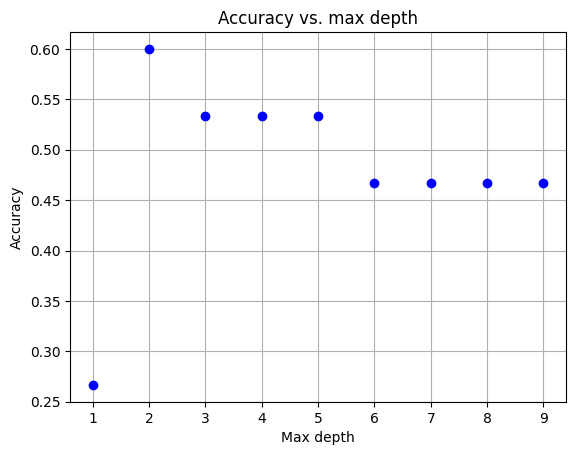

In [65]:
# Decision Tree
accuracy_list = []
plt.figure()
for depth in range(1,10):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=15)
    accuracy = cross_val_score(dt, X, y, cv=kf, scoring='accuracy')
    avg_accuracy = accuracy.mean() 
    print(avg_accuracy)
    accuracy_list.append(avg_accuracy)
    plt.plot(depth, avg_accuracy, 'bo')
print(f"Best max depth is {accuracy_list.index([max(accuracy_list)])+1}")

plt.title('Accuracy vs. max depth')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

   AGE  FEVER  ABP  FIBRILLATION  H-TRAUMA  B-TRAUMA  SPEAK  MA  PARALYSIS  \
0   66      0    1             1         0         0      1   1          0   
1   22      0    1             1         1         1      0   0          0   
2   20      0    0             0         0         1      1   1          0   
3   77      1    0             0         0         0      1   1          0   
4   90      1    0             0         0         0      1   1          0   

   HEMORRAGY  
0          0  
1          1  
2          0  
3          0  
4          0  


[Text(0.6, 0.8333333333333334, 'x[8] <= 0.5\ngini = 0.498\nsamples = 15\nvalue = [8, 7]'),
 Text(0.4, 0.5, 'x[9] <= 0.5\ngini = 0.444\nsamples = 12\nvalue = [8, 4]'),
 Text(0.5, 0.6666666666666667, 'True  '),
 Text(0.2, 0.16666666666666666, 'gini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.7, 0.6666666666666667, '  False')]

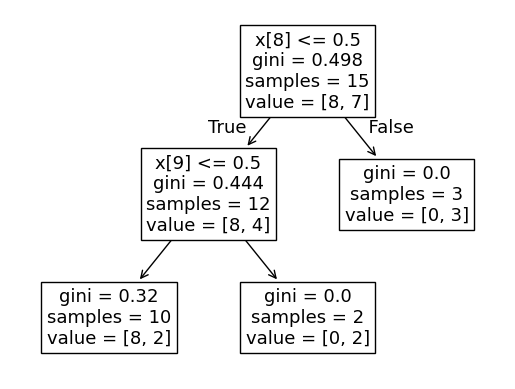

In [4]:
print(X.head())
# Plot tree
dt = DecisionTreeClassifier(max_depth=2, random_state=15)
dt = dt.fit(X, y)
plot_tree(dt, fontsize=13)
#y_pred_dt = dt.predict(X_test)

In [ ]:
# plt.figure(figsize=(20, 7))
# plt.hist(X.AGE, bins=np.arange(min(X.AGE), max(X.AGE) + 2), align="left", rwidth=0.5)
# plt.xticks(np.arange(min(X.AGE), max(X.AGE) + 1, 1))

# intervals = [0, 33, 70.5, 100]
# X[["dummy0", "dummy1", "dummy2"]] = pd.get_dummies(pd.cut(X.AGE, intervals), dtype=int)
# X.drop(["AGE", "dummy0"], axis=1, inplace=True)
# X.head()


0.5333333333333333
0.4666666666666667
0.4
0.4
0.4
0.4
0.3333333333333333
0.5333333333333333
0.4666666666666666
0.5333333333333333
0.4666666666666667
0.5333333333333333


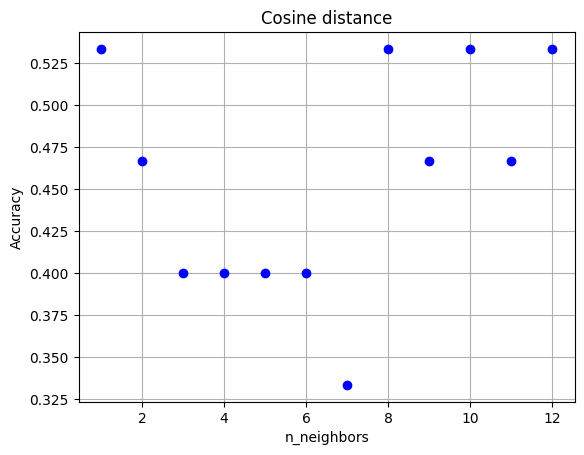

In [ ]:
accuracy_list=[]
plt.figure()
intervals = [0, 33, 70.5, 100]
X_dummy_age = X
X_dummy_age[["dummy0", "dummy1", "dummy2"]] = pd.get_dummies(
    pd.cut(X.AGE, intervals), dtype=int
)
X_dummy_age.drop(["AGE", "dummy0"], axis=1, inplace=True)
X_dummy_age.head()

# KNN
for n_neighbors in range(1,13):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    accuracy = cross_val_score(knn, X_dummy_age, y,  scoring='accuracy')
    avg_accuracy = accuracy.mean()
    print(avg_accuracy)
    plt.plot(n_neighbors, avg_accuracy, 'bo')

plt.title('KNN with categorical age')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('Accuracy knn dummy age with different k', transparent=True)
plt.show()

In [49]:
#Create a custom KNN that weight Urgent patients more.
# not urgent distance = 1/(distance*weight)
# weight is set to 2 by default

class CustomWeightedKNN(KNeighborsClassifier):
    def __init__(self, n_neighbors=5, metric='cosine', p=2, weight=2):
        super().__init__(n_neighbors=n_neighbors, metric=metric, p=p)
        self.weight = weight
    def _compute_custom_weights(self, distances, indices, labels):
        # Implement your custom logic for weights here
        # Example: weight distances inversely, prioritize "urgent" labels
        weights = np.zeros_like(distances)
        for i, neighbors in enumerate(indices):
            for j, neighbor in enumerate(neighbors):
                label = labels[neighbor]
                if label == 1:  # Assuming "urgent" is represented by 1
                    weights[i, j] = distances[i, j] * self.weight # Add small value to avoid division by zero
                else:
                    weights[i, j] = distances[i, j]
        return weights
    
    def predict(self, X):
        distances, indices = self.kneighbors(X)
        labels = self._y
        weights = self._compute_custom_weights(distances, indices, labels)
        weighted_votes = np.zeros((X.shape[0], len(np.unique(labels))))
        
        for i, neighbors in enumerate(indices):
            for j, neighbor in enumerate(neighbors):
                label = labels[neighbor]
                weighted_votes[i, label] += weights[i, j]
        
        return weighted_votes.argmax(axis=1)


# Define a custom weighted accuracy function
def weighted_accuracy(y_true, y_pred):
    score = 0
    positives = np.sum(y_true == 1)
    negatives = np.sum(y_true == 0)
    for yt, yp in zip(y_true, y_pred):
        if yt == yp == 1:
            score += 2
        elif yt == yp == 0:
            score += 1
    score = score/(positives*2+negatives)
    return score

def weighted_accuracy2(y_true, y_pred):
    error = 0
    positives = np.sum(y_true == 1)
    negatives = np.sum(y_true == 0)
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            error = error + 2
        elif yt == 0 and yp == 1:
            error = error + 1
    accuracy = 1 - error/(positives*2+negatives)
    return error/(positives*2+negatives), accuracy
            
    

# Create a scorer for the custom metric. It will be used as a parameter in the cross validation
weighted_accuracy_scorer = make_scorer(weighted_accuracy)


In [34]:
y_true = np.array([0,0,0,1,0,1,1,1])
y_pred = np.array([1,0,0,1,0,1,0,0])
print(weighted_accuracy(y_true, y_pred))
print(weighted_accuracy2(y_true, y_pred))

0.5833333333333334
(np.float64(0.4166666666666667), np.float64(0.5833333333333333))


0.4
0.6666666666666666
0.4666666666666667
0.4666666666666667
0.5333333333333333
0.6
0.5333333333333333
0.4666666666666667
0.5333333333333333
0.4666666666666667


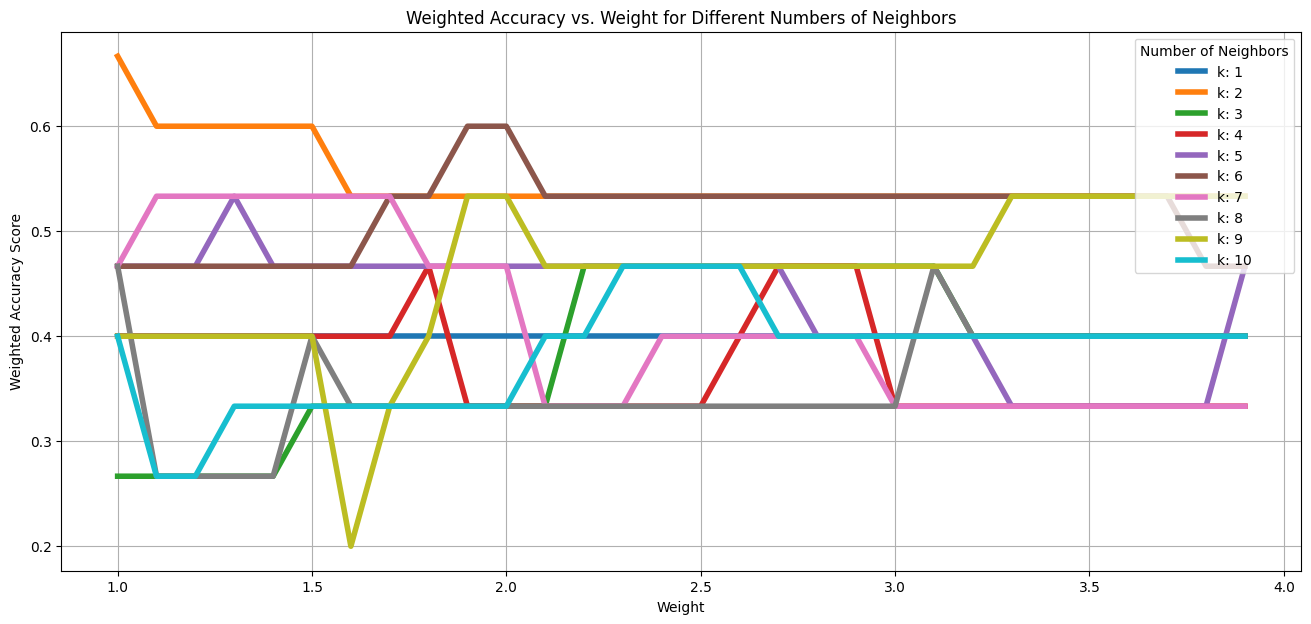

In [50]:
# Define hyperparameters for tuning
weights = np.arange(1, 4, 0.1)  # Small step for weights
n_neighbors_list = np.arange(1, 11)  # Range of neighbors

results = {}

# Perform cross-validation and collect results
for k in n_neighbors_list:
    for weight in weights:
        Custom_KNN = CustomWeightedKNN(n_neighbors=k, metric="cosine", weight=weight)
        score = cross_val_score(Custom_KNN, X, y, cv=kf, scoring=weighted_accuracy_scorer).mean()
        if k not in results:
            results[k] = []
        results[k].append([weight, score])
        #print(f"Neighbors: {k}, Weight: {weight:.1f}, Weighted Accuracy: {score:.4f}")

fig = plt.figure(figsize = (16,7))
ax = fig.subplots()
for k, data in results.items():
    weights, scores = zip(*data)
    print(max(scores))
    ax.plot(weights, scores, label = f"k: {k}", linewidth = 4)


plt.title('Weighted Accuracy vs. Weight for Different Numbers of Neighbors')
plt.xlabel('Weight')
ax.xbound = (0,5)
plt.ylabel('Weighted Accuracy Score')
plt.legend(title='Number of Neighbors')
plt.grid(True)
plt.show()
# Convert results into a plottable format

In [41]:
Custom_KNN = CustomWeightedKNN(n_neighbors=2, metric="cosine", weight=1.25)
accuracy = cross_val_score(Custom_KNN, X, y, cv=kf, scoring='accuracy').mean()
weighted_acc = cross_val_score(Custom_KNN, X, y, cv=kf, scoring=weighted_accuracy_scorer).mean()
print(f"Custom knn accuracy = {accuracy}")
print(f"Custom knn weighted accuracy = {weighted_acc}")

Custom knn accuracy = 0.6
Custom knn weighted accuracy = 0.6


In [51]:
# Load test set
test_data = pd.read_excel('P5_emergency_department.xlsx', sheet_name=1)
X_test = test_data.drop(['PATIENT','CODE', 'Unnamed: 12', 'REAL CODE'], axis=1)
y_test = test_data['REAL CODE']
y_test = y_test.map({'URGENT': 1, 'NOT URGENT': 0})

Decision tree accuracy = 0.6
Decision tree weighted accuracy = 0.5333333333333333
Knn accuracy = 0.6
Knn weighted accuracy = 0.4666666666666667
Custom knn accuracy = 0.6
Knn weighted accuracy = 0.5333333333333333


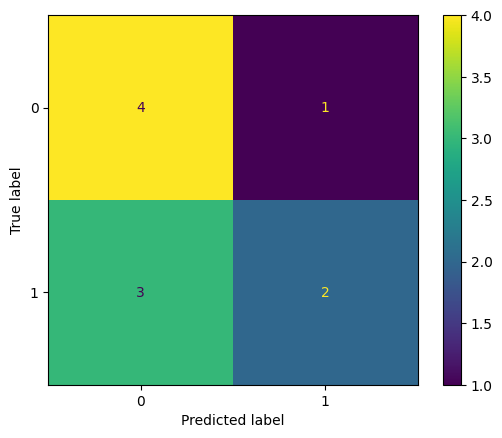

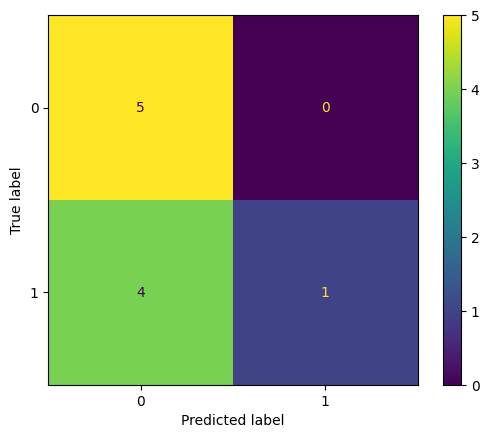

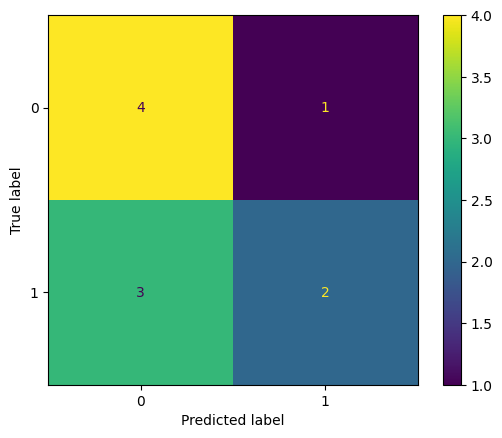

In [56]:
# Test decition tree, knn and custom knn
dt = DecisionTreeClassifier(max_depth=2, random_state=15)
dt = dt.fit(X, y)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
weighted_acc = weighted_accuracy(y_test, y_pred)
print(f"Decision tree accuracy = {accuracy}")
print(f"Decision tree weighted accuracy = {weighted_acc}")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

intervals = [0, 33, 70.5, 100]
# X_test[["dummy0", "dummy1", "dummy2"]] = pd.get_dummies(
#     pd.cut(X_test.AGE, intervals), dtype=int)
# X_test.drop(["dummy0", "AGE"], axis=1, inplace=True)
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
knn.fit(X, y)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
weighted_acc = weighted_accuracy(y_test, y_pred)
print(f"Knn accuracy = {accuracy}")
print(f"Knn weighted accuracy = {weighted_acc}")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

custom_knn = CustomWeightedKNN(n_neighbors=2, metric='cosine', weight=1.25)
custom_knn.fit(X, y)
y_pred = custom_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
weighted_acc = weighted_accuracy(y_test, y_pred)
print(f"Custom knn accuracy = {accuracy}")
print(f"Knn weighted accuracy = {weighted_acc}")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [54]:
X_test[["dummy0", "dummy1", "dummy2"]] = pd.get_dummies(
    pd.cut(X_test.AGE, intervals), dtype=int
)
X_test.drop(["dummy0", "AGE"], axis=1, inplace=True)
X_test.head()

,FEVER,ABP,FIBRILLATION,H-TRAUMA,B-TRAUMA,SPEAK,MA,PARALYSIS,HEMORRAGY,dummy1,dummy2
0,1,0,0,0,0,1,0,0,0,0,0
1,0,1,0,1,0,1,1,0,0,0,1
2,0,1,0,0,1,1,0,0,0,0,1
3,0,0,0,0,0,1,1,0,0,1,0
4,0,0,1,1,0,0,0,1,0,0,1


([<matplotlib.axis.XTick at 0x131dec690>,
 [Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40'),
  Text(41, 0, '41'),
  Text(42, 0, '42'),
  Text(43, 0, '43'),
  Text(44, 0, '44'),
  Text(45, 0, '45'),
  Text(46, 0, '46'),
  Text(47, 0, '47'),
  Text(48, 0, '48'),
  Text(49, 0, '49'),
  Text(50, 0, '50'),
  Text(51, 0, '51'),
  Text(52, 0, '52'),
  Text(53, 0, '53'),
  Text(54, 0, '54'),
  Text(55, 0, '55'),
  Text(56, 0, '56'),
  Text(57, 0, '57'),
  Text(58, 0, '58'),
  Text(59, 0, '59'),
  Text(60, 0, '60'),
  Text(61, 0, '61'),
  Text(62, 0, '62'),
  Text(63, 0,

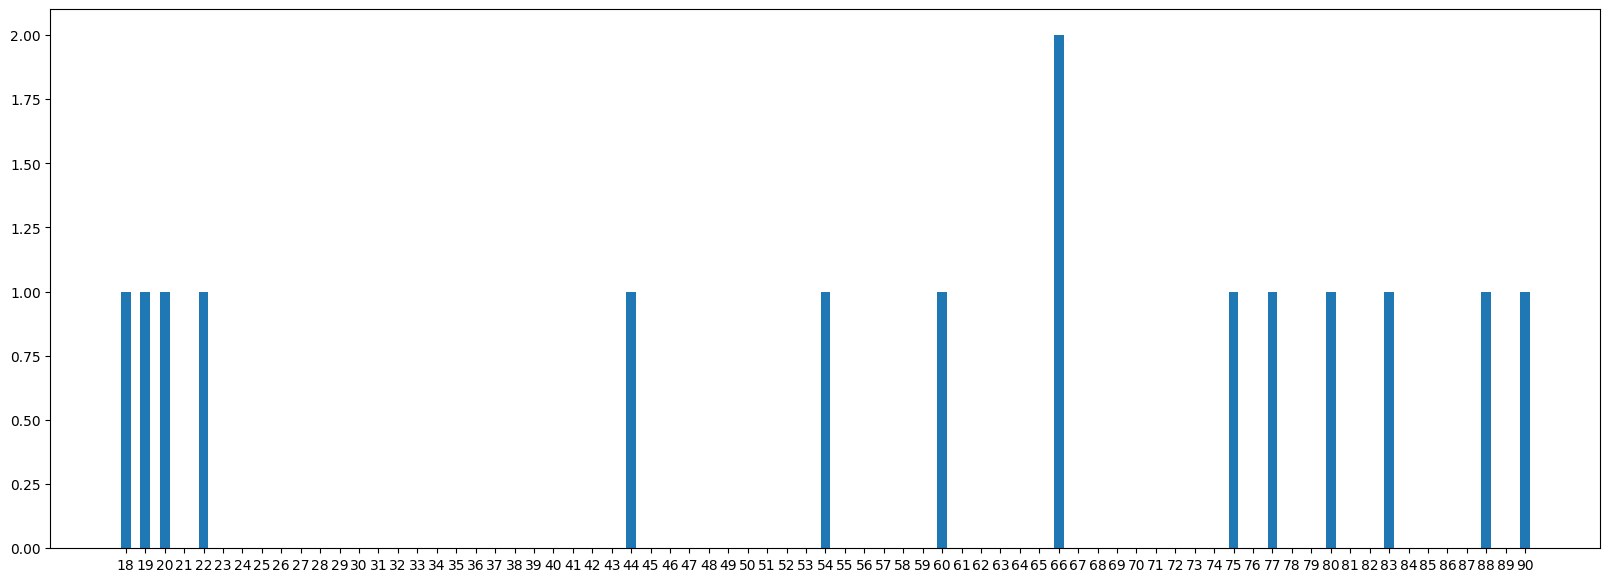

In [ ]:
# plt.hist(X.AGE, bins= np.linspace(min(X.AGE), max(X.AGE),100))
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_excel("P5_emergency_department.xlsx")
X = data.drop(["CLASS", "PATIENT"], axis=1)







0     66
1     22
2     20
3     77
4     90
5     66
6     54
7     44
8     88
9     83
10    75
11    19
12    60
13    80
14    18
Name: AGE, dtype: int64


,FEVER,ABP,FIBRILLATION,H-TRAUMA,B-TRAUMA,SPEAK,MA,PARALYSIS,HEMORRAGY,dummy1,dummy2
0,0,1,1,0,0,1,1,0,0,1,0
1,0,1,1,1,1,0,0,0,1,0,0
2,0,0,0,0,1,1,1,0,0,0,0
3,1,0,0,0,0,1,1,0,0,0,1
4,1,0,0,0,0,1,1,0,0,0,1


In [ ]:
X.head()

,AGE,FEVER,ABP,FIBRILLATION,H-TRAUMA,B-TRAUMA,SPEAK,MA,PARALYSIS,HEMORRAGY
0,66,0,1,1,0,0,1,1,0,0
1,22,0,1,1,1,1,0,0,0,1
2,20,0,0,0,0,1,1,1,0,0
3,77,1,0,0,0,0,1,1,0,0
4,90,1,0,0,0,0,1,1,0,0
